In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
# import pandas_ta as ta
warnings.filterwarnings("ignore")

#Fetching data from Yfinance
df=yf.download("BTC-USD",start="2022-01-01",end="2025-01-01")

if isinstance(df.columns,pd.MultiIndex):
  df.columns = [col[0] for col in df.columns]

#Initialinzing matplotlib
plt.figure(figsize=(12,8))


[*********************100%***********************]  1 of 1 completed


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [9]:
# Coding Given Indicators

def Indicators(df : pd.DataFrame):

  # Stochastic_Indicator
  df=df.copy()
  df["L_17"]=df["Low"].rolling(17).min()
  df["H_17"]=df["High"].rolling(17).max()
  df["K"]=((df["Close"]-df["L_17"])/(df["H_17"]-df["L_17"]))*100
  df["K"].fillna(0,inplace=True)
  df["D"]=df["K"].rolling(3).mean().fillna(0)

  # AD_Indicator
  df=df.copy()
  df["H-L"]=df["High"]-df["Low"]
  df["MFM"]=(2*df["Close"]-df["High"]-df["Low"])/df["H-L"] # MFM : Money Flow Multiplier
  df["MFV"]=df["MFM"]*df["Volume"]
  df["AD"]=df["MFV"].cumsum()

  # VIX_Indicator
  df=df.copy()
  df['logreturns'] = np.log(df['Close'] / df['Close'].shift(1))
  lookback = 22  # 22 trading days (approx 1 month)
  df['btc_vix'] = df['logreturns'].rolling(lookback).std() * np.sqrt(365) * 100
  # VIX Filter
  df['vix_filter'] = (df['btc_vix'] > 30)

  return df

In [10]:
# ADDED ADX ADDITIONALLY TO CAPTURE ONLY STRONG TRENDS

def calculate_adx(df, period=13):

    # Adding ADX, +DI, and -DI columns to a DataFrame.
    # df: pandas DataFrame with columns 'High', 'Low', 'Close'
    # period: smoothing period (default 14 but here tuned to 13)
    # Returns df with added columns: 'ADX', '+DI', '-DI'


    df = df.copy()

    # Step 1: Calculating directional movements
    df['UpMove'] = df['High'].diff()
    df['DownMove'] = df['Low'].shift(1) - df['Low']

    df['+DM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > 0), df['UpMove'], 0.0)
    df['-DM'] = np.where((df['DownMove'] > df['UpMove']) & (df['DownMove'] > 0), df['DownMove'], 0.0)

    # Step 2: Calculating True Range (TR)
    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        (df['High'] - df['Close'].shift()).abs(),
        (df['Low'] - df['Close'].shift()).abs()
    ])

    # Step 3: Smooth TR, +DM, -DM using Wilder's EMA
    df['TR_smooth'] = df['TR'].ewm(alpha=1/period, adjust=False).mean()
    df['+DM_smooth'] = df['+DM'].ewm(alpha=1/period, adjust=False).mean()
    df['-DM_smooth'] = df['-DM'].ewm(alpha=1/period, adjust=False).mean()

    # Step 4: Calculating +DI and -DI
    df['+DI'] = 100 * df['+DM_smooth'] / df['TR_smooth']
    df['-DI'] = 100 * df['-DM_smooth'] / df['TR_smooth']

    # Step 5: Calculating DX
    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])

    # Step 6: Calculating ADX
    df['ADX'] = df['DX'].ewm(alpha=1/period, adjust=False).mean()

    # Cleaning up temporary columns
    df.drop(['UpMove','DownMove','+DM','-DM','TR','TR_smooth','+DM_smooth','-DM_smooth','DX'], axis=1, inplace=True)

    return df


In [11]:
def Final_Signal_Generator(df : pd.DataFrame):
  # Prerequisite Indicators : Stochastic_Oscillator , Accumulation-Distribution Indicator and VIX Indicator
  # Additional Indicator to enhance performance : ADX

  df=df.copy()
  df=Indicators(df)
  df = calculate_adx(df, period=13)


  df["tradesignal"] = 0

  # Using Stochastic_Oscillator and Accumulation-Distribution Indicator

  Stochastic_buy=((df["K"]>=20) & (df["K"].shift(1)<20))
  Stochastic_sell=((df["K"]<=60) & (df["K"].shift(1)>80))

  AD_Buy=((df['AD'] > df['AD'].shift(1)) & (df['Close'] < df['Close'].shift(1)))
  AD_Sell=((df['AD'] < df['AD'].shift(1)) & (df['Close'] > df['Close'].shift(1)))

  #Using ADX to filter only strong trends
  adx_trade_allowed = df['ADX'] > 21

  # Final Trade Signals
  buy = ((Stochastic_buy | AD_Buy) & adx_trade_allowed & df['vix_filter'])
  sell=((Stochastic_sell | AD_Sell) & adx_trade_allowed & df["vix_filter"])

  df.loc[sell,"tradesignal"]= -1
  df.loc[buy,"tradesignal"]=1

  return df

In [12]:
def backtester(df):
  capital=1000000
  winning_trades=0
  losing_trades=0
  initial_capital=1000000
  last_capital=1000000
  shares=0
  peak=capital
  totalprofit=0
  drawdown=[]
  position=0
  sl=0.05 #Stoploss=5% ,We are using trade stop loss , if closing price decreases 5% less than entry price , we exit
  short_sl=0.01 # Shorting Stoploss=1%
  entry_price=0
  short_entry_price=0
  df["portfolio"]=0
  df["return"]=0


  for i in range(len(df["Close"])):
    closing_today=df["Close"].iloc[i]


    # LONG STOP LOSS(5%)
    if (position==1 and closing_today <= entry_price * (1 - sl) ):

      capital += shares * closing_today
      shares = 0
      entry_price = 0
      if(last_capital<capital):
        winning_trades+=1
        totalprofit+=capital-last_capital
      else:
        losing_trades+=1


    # SHORT STOP LOSS (1%)
    if position == -1 and closing_today > short_entry_price * (1+short_sl):
        capital= capital+ shares*(short_entry_price-closing_today)

        position = 0
        shares = 0
        if(last_capital<capital):
          totalprofit+=capital-last_capital
          winning_trades+=1
          totalprofit+=capital-last_capital
        else:
          losing_trades+=1

    # Updating Portfolio
    if position==0 or position==1:
      df["portfolio"].iloc[i]=capital+shares*closing_today
    else:
      df["portfolio"].iloc[i]=capital+shares*(short_entry_price-closing_today)

    # Updating Drawdowns (if it occured)
    if(df["portfolio"].iloc[i]>peak):
      peak=df["portfolio"].iloc[i] #Used in finding drawdown
    if(peak-df["portfolio"].iloc[i]>0):
      drawdown.append(df["portfolio"].iloc[i]-peak) #Finding Drawdown


    # Exiting Long
    if((df["tradesignal"].iloc[i]==-1)and position==1):
      capital=capital+(shares*closing_today)
      shares=0
      if(last_capital<capital):
        winning_trades+=1
        totalprofit+=capital-last_capital
      else:
        losing_trades+=1
      position=0

    # Exiting Short
    elif((df["tradesignal"].iloc[i]==1) and position==-1):
      capital= capital+ shares*(short_entry_price-closing_today)
      shares=0
      if(last_capital<capital):
        winning_trades+=1
        totalprofit+=capital-last_capital
      else:
        losing_trades+=1
      position=0

    # Entering Long
    if(df["tradesignal"].iloc[i]==1 and position==0):
      last_capital=capital
      shares=capital//closing_today
      capital=capital-shares*closing_today
      entry_price=closing_today
      position=1

    # Entering Short
    elif(df["tradesignal"].iloc[i]==-1 and position==0 and (df["AD"].diff().iloc[i] < df["AD"].diff().rolling(5).mean().iloc[i])):
      last_capital=capital
      shares=capital//closing_today
      short_entry_price=closing_today
      position=-1


  # Exiting all trades on last day
  if(position==1):
    capital=capital+shares*df["Close"].iloc[-1]
    if(last_capital<capital):
        totalprofit+=capital-last_capital
        winning_trades+=1
        totalprofit+=capital-last_capital
    else:
        losing_trades+=1
  elif(position==-1):
    capital=capital+shares*(short_entry_price-df["Close"].iloc[-1])
    if(last_capital<capital):
        totalprofit+=capital-last_capital
        winning_trades+=1
        totalprofit+=capital-last_capital
    else:
        losing_trades+=1



  # Finding PnL , in this case profit
  profit=(capital-initial_capital)/initial_capital*100

  # Finding Max Drawdown
  drawdowns=pd.Series(drawdown)
  max_drawdown=drawdowns.min()

  # Finding Sharpe and Sortino
  df["returns"]  =returns= df['portfolio'].pct_change().fillna(0)
  sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
  downside = returns[returns < 0]
  sortino = (returns.mean() / downside.std()) * np.sqrt(252)

  # Plotting Portfolio
  plt.plot(df["portfolio"])
  plt.show()


  close = df["Close"]



  # Buy & Hold benchmark
  btc_qty = initial_capital / close.iloc[0]          # BTC bought on day 1
  benchmark_value = btc_qty * close.iloc[-1]         # Value on last day
  benchmark_profit = benchmark_value - initial_capital
  benchmark_return = (benchmark_value / initial_capital - 1) * 100


  # Printing Portfolio Metrics
  print("Benchmark Final Value =", benchmark_value)
  print("Benchmark Profit =", benchmark_profit)
  print("Benchmark Return % =", benchmark_return)
  print("Total Profit =",totalprofit)
  print("Net Profit =",capital-initial_capital)
  print("Net Return =",profit,"%")
  print("Sharpe ratio =",sharpe_ratio)
  print("Sortino ratio =",sortino)
  print("Trades Won =",winning_trades)
  print("Trades Lost =",losing_trades)
  print("Total Trades =",winning_trades+losing_trades)
  print("Volatility =",df["returns"].std())
  print("Max Drawdown %=",max_drawdown*100/peak)




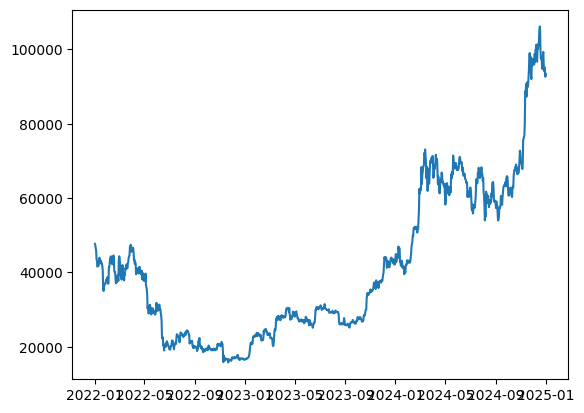

In [13]:
# Plotting Stock Prices for better comparison with portfolio
plt.plot(df["Close"])

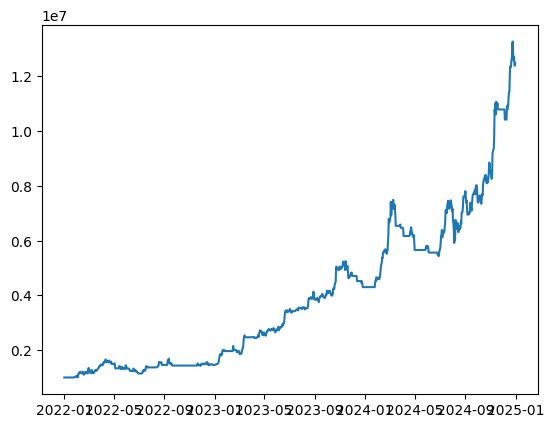

Benchmark Final Value = 1959225.1657625472
Benchmark Profit = 959225.1657625472
Benchmark Return % = 95.92251657625472
Total Profit = 17225248.890625
Net Profit = 11490140.228515625
Net Return = 1149.0140228515625 %
Sharpe ratio = 1.8366971178794869
Sortino ratio = 2.459457590170139
Trades Won = 41
Trades Lost = 50
Total Trades = 91
Volatility = 0.021989145843718343
Max Drawdown %= -15.519625050016282


In [14]:
backtester(Final_Signal_Generator(df))

This trading algorithm for Bitcoin :
* Combines multiple technical indicators to generate entry and exit signals
* Uses  Stochastic Oscillator to identify overbought/oversold conditions
* Uses Accumulation-Distribution (AD) Indicator to gauge buying/selling pressure
* Uses VIX Indicator to filter trades during high volatility periods.
* Additionally the ADX (Average Directional Index) is incorporated to ensure trades are only taken during strong trends.

The strategy generates buy signals when either the Stochastic Oscillator indicates an oversold condition (K crossing above 20) or the AD Indicator shows accumulation, provided the ADX is above 21 (strong trend) and the VIX filter is active (volatility > 30).  
Conversely, sell signals are triggered when the Stochastic becomes overbought (K crossing below 60 from above 80) or the AD shows distribution, again filtered by same ADX and VIX conditions.

The backtester executes trades with a 5% stoploss for long positions and a 1% stoploss for shorts, managing risk while capturing momentum and reversal opportunities. This multi indicator approach aims to improve signal reliability by combining trend strength, volatility, and volume flow confirmation.